In [25]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from skimage.transform import radon, rescale
from scipy.interpolate import interp1d
import time

In [26]:
save_here = "C:/Users/tomerf/Desktop/reconstruction_examples_for_master/figures/"

In [27]:
# Object creation

# Create blank image
img_size = 512
phantom = np.zeros((img_size, img_size), dtype=np.uint8)

# Circle parameters
circle_center = (img_size // 2, img_size // 2)
circle_radius = 100
cv2.circle(phantom, circle_center, circle_radius, color=255, thickness=-1)

# Rectangle parameters (placed to the right of the circle)
rect_top_left = (img_size // 2 + 120, img_size // 2 - 160)
rect_bottom_right = (rect_top_left[0] + 60, rect_top_left[1] + 120)
cv2.rectangle(phantom, rect_top_left, rect_bottom_right, color=255, thickness=-1)

# Normalize to float [0,1] for Matplotlib
phantom_norm = phantom.astype(np.float32) / 255.0

In [28]:
%matplotlib notebook
# Save as vector images
plt.figure(figsize=(5, 5))
plt.imshow(phantom_norm, cmap='gray', interpolation='none')
# plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig(save_here + "phantom_circle_rectangle.svg", format='svg', bbox_inches='tight', pad_inches=0)
# plt.savefig(save_here + "phantom_circle_rectangle.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()


<IPython.core.display.Javascript object>

In [ ]:
# Create the sinogram

azi_angles = np.linspace(0,180.0, 180, endpoint=False)
sinogram = radon(phantom_norm, azi_angles)
sinogram.shape

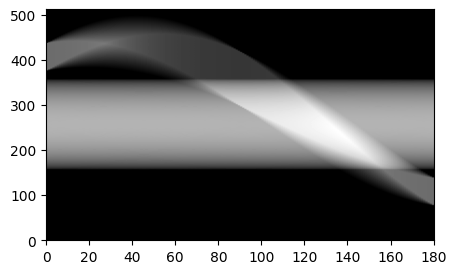

In [20]:
# plot the sinogram

plt.rcdefaults()
plt.style.use('default')

plt.figure(figsize=(5,3), facecolor='white')
plt.imshow(
    sinogram,                        # no transpose here
    cmap='gray',
    aspect='auto',                   # don’t squash vertically
    origin='lower',                  # detector pixel 0 at the bottom
    extent=(0, 180, 0, sinogram.shape[0])  # x-axis 0–180 deg
)
plt.savefig(save_here + "phantom_sinogram.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "phantom_sinogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# Another plot of the sinogram

plt.rcdefaults()
plt.style.use('default')

plt.figure(figsize=(6,6), facecolor='white')
plt.axis("off")
plt.imshow(
    sinogram,                        # no transpose here
    cmap='gray',
    aspect='auto',                   # don’t squash vertically
    origin='lower',                  # detector pixel 0 at the bottom
    extent=(0, 180, 0, sinogram.shape[0])  # x-axis 0–180 deg
)
plt.savefig(save_here + "phantom_sinogram_no_ax.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "phantom_sinogram_no_ax.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
angle_45 = np.array([45])
angle_45.shape

In [ ]:
# one line of the siogram

sinogram_45 = radon(phantom_norm, angle_45)

In [ ]:
# the 1d profile of the sinogram

# Assuming sinogram is 2D: (detector_pixels, angles)
sinogram_45 = sinogram[:, 45]  # Get 45° projection (1D)

# Original vector
x = np.arange(len(sinogram_45))
y = sinogram_45

# Interpolation function (cubic is smooth)
interp_func = interp1d(x, y, kind='cubic')

# New, denser x-axis
x_dense = np.linspace(0, len(y) - 1, 10 * len(y))  # 10× more points
y_dense = interp_func(x_dense)

# Plot it
plt.figure(figsize=(5, 3), facecolor='white')
plt.plot(x_dense, y_dense, color='blue', linewidth=1.5)
plt.axis('off')
plt.gca().set_position([0, 0, 1, 1])
plt.savefig(save_here + "45_line.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line.png", format='png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# same profile but on the sinogram plane itself

theta_index = 45
column = sinogram[:, theta_index]  # shape (N,)

# Repeat the column to make a visible image (e.g. 20 pixels wide)
projection_img = np.tile(column[:, np.newaxis], (1, 20))  # shape (N, 20)

plt.figure(figsize=(0.5, 6), facecolor='white')  # Aspect ratio = tall
plt.axis("off")
plt.imshow(
    projection_img,
    cmap='gray',
    aspect='auto',
    origin='lower',  # flip to 'upper' if needed
    extent=(44.5, 45.5, 0, len(column)),
    interpolation='none'  # IMPORTANT: preserve hard pixel edges
)
plt.tight_layout()
plt.savefig(save_here + "45_line_all_object.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line_all_object.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "45_line_all_object.png", format='png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# the phantom and its fourier transform

phantom_fourier = np.fft.fft2(phantom_norm)
phantom_fourier = np.fft.fftshift(phantom_fourier)
phantom_fourier = 10 * np.log(1 + np.abs(phantom_fourier))

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(phantom_norm, cmap="gray")
plt.axis("off")

plt.subplot(122)
plt.imshow(phantom_fourier, cmap="gray")
plt.axis("off")

plt.show()

In [14]:
# a function that construct the fourier transform of the object using the sinogram slice by slice

%matplotlib notebook

def foruier_slice_theorem(sino, fourier_plane, complex_fft, all_angles, slice_angle):
    
    size = sino.shape[0]
    center = size // 2
    
    angle_index = np.where(all_angles == slice_angle)[0][0]
    slice_angle_rad = np.deg2rad(slice_angle)
    
    projection  = sino[:, angle_index]
    
    slice_fft = np.fft.fft(np.fft.fftshift(projection))
    slice_fft = np.fft.fftshift(slice_fft)
    
    magnitude = np.abs(slice_fft)
    magnitude = np.log1p(magnitude)  # log(1 + |F|) for better contrast
    magnitude /= magnitude.max()
    
    # Draw in both directions
    for i in range(size):
        offset = i - center  # goes from -center to +center
        
        # radial coordinate in frequency domain
        x = int(round(center - offset * np.cos(slice_angle_rad)))
        y = int(round(center + offset * np.sin(slice_angle_rad)))
    
        if 0 <= x < size and 0 <= y < size:
            fourier_plane[y, x] = magnitude[i]
            complex_fft[y, x] = slice_fft[i]


fourier_plane = np.zeros((sinogram.shape[0], sinogram.shape[0]), dtype=np.float32)
complex_plane = np.zeros_like(fourier_plane) # this is for the reconstruction we need the complex values too
snapshot_angles = [0, 45, 90, 135, 179]


plt.ion()
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(fourier_plane, cmap='gray', vmin=0, vmax=1)
title = ax.set_title("")
ax.axis('off')

# Loop through angles
for i, ang in enumerate(azi_angles):
    foruier_slice_theorem(sinogram, fourier_plane, complex_plane, azi_angles, ang)
    
    img.set_data(fourier_plane)         # update image
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(1)
    
    if ang in snapshot_angles:
        fig.savefig(save_here + f"fourier_slice_{int(ang)}deg.pdf", format='pdf',  dpi=300, bbox_inches='tight', pad_inches=0)

plt.ioff()
plt.show()

<IPython.core.display.Javascript object>

C:\Users\tomerf\AppData\Local\Temp\ipykernel_22336\1638743415.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  complex_fft[y, x] = slice_fft[i]


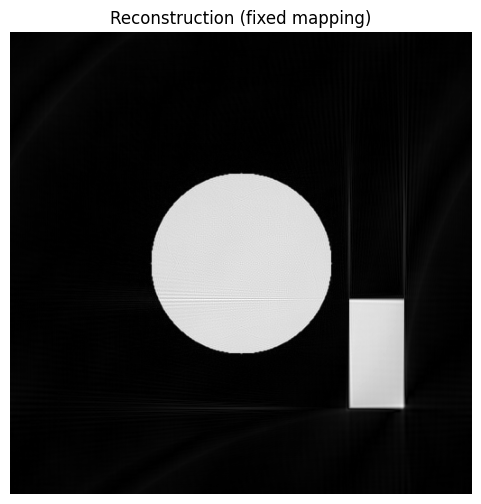

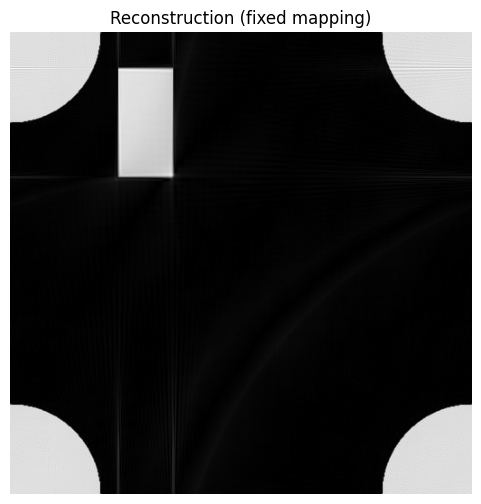

In [19]:

# Assume: sinogram, azi_angles, size already defined
S = sinogram.shape[0]
N = len(azi_angles)
center = S // 2

# Compute 1D FFTs (rows of sinogram)
sinogram_fft_rows = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram, axes=0), axis=0), axes=0)

# Flatten all FFT samples with their corresponding positions
r = np.arange(S) - center
angles_rad = np.deg2rad(azi_angles)
r_grid, angle_grid = np.meshgrid(r, angles_rad)

# Coordinates in 2D Fourier domain
srcx = center + r_grid * np.cos(angle_grid)
srcy = center + r_grid * np.sin(angle_grid)
values = sinogram_fft_rows.T.flatten()  # each column was a projection

# Destination grid
dstx, dsty = np.meshgrid(np.arange(S), np.arange(S))
dst_points = np.stack((dsty.ravel(), dstx.ravel()), axis=-1)

# Interpolation to Cartesian grid
from scipy.interpolate import griddata

fft2_cartesian = griddata(
    (srcy.flatten(), srcx.flatten()),
    values,
    dst_points,
    method='cubic',  # or 'linear' if sparse
    fill_value=0
).reshape((S, S))

# Inverse FFT
ifft_input = np.fft.ifftshift(fft2_cartesian)
reconstructed = np.fft.ifft2(ifft_input)
reconstructed = np.fft.fftshift(reconstructed)
reconstructed = np.abs(reconstructed)
reconstructed -= reconstructed.min()
reconstructed /= reconstructed.max()

# Show
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap='gray')
plt.axis('off')
plt.title("Reconstruction (fixed mapping)")
plt.show()
# Interpolation to Cartesian grid
from scipy.interpolate import griddata

fft2_cartesian = griddata(
    (srcy.flatten(), srcx.flatten()),
    values,
    dst_points,
    method='cubic',  # or 'linear' if sparse
    fill_value=0
).reshape((S, S))

# Inverse FFT
ifft_input = np.fft.ifftshift(fft2_cartesian)
reconstructed = np.fft.ifft2(ifft_input)
reconstructed = np.abs(reconstructed)
reconstructed -= reconstructed.min()
reconstructed /= reconstructed.max()

# Show
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap='gray')
plt.axis('off')
plt.title("Reconstruction (fixed mapping)")
plt.show()

In [15]:
# to stop the interactive mode

%matplotlib inline

plt.ioff()              # Turn off interactive mode
plt.close('all')        # Close all figures
plt.rcdefaults()        # Reset rcParams to default
plt.style.use('default')  # Clear any Jupyter or dark style overrides

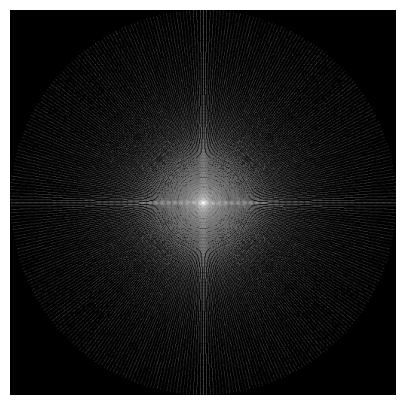

In [23]:
# the final result of the reconstruction

plt.figure(figsize=(10,5))

plt.imshow(fourier_plane, cmap='gray', vmin=0, vmax=1)
plt.axis("off")
plt.savefig(save_here + "complete_fourier_slice_theorem.svg", format='svg', bbox_inches='tight', pad_inches=0)
plt.savefig(save_here + "complete_fourier_slice_theorem.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.interpolate
import scipy.misc
import scipy.ndimage.interpolation
import skimage

S = 512  # Size of target, and resolution of Fourier space
N = 259  # Number of sinogram exposures (odd number avoids redundant direct opposites)

V = 100  # Range on fft plots


# Convenience function
def sqr(x):
    return x * x


# Return the angle of the i-th (of 0-to-N-1) sinogram exposure in radians.
def angle(i):
    return (math.pi * i) / N


# Prepare a target image
x, y = np.meshgrid(np.arange(S) - S / 2, np.arange(S) - S / 2)
mask = sqr(x) + sqr(y) <= sqr(S / 2 - 10)
target = phantom

plt.figure()
plt.title("Target")
plt.imshow(target)
plt.gray()
plt.savefig("00_target.png")

# Project the sinogram (ie calculate Radon transform)
sinogram = np.array(
    [
        np.sum(
            scipy.ndimage.interpolation.rotate(
                target,
                np.rad2deg(angle(i)),  # NB rotate takes degrees argument
                order=3,
                reshape=False,
                mode="constant",
                cval=0.0,
            ),
            axis=0,
        )
        for i in range(N)
    ]
)

plt.figure()
plt.imshow(sinogram)

plt.savefig("01_sinogram.png")

# Fourier transform the rows of the sinogram, move the DC component to the row's centre
sinogram_fft_rows = scipy.fftpack.fftshift(
    scipy.fftpack.fft(scipy.fftpack.ifftshift(sinogram, axes=1)), axes=1
)

plt.figure()
plt.subplot(121)
plt.title("Sinogram rows FFT (real)")
plt.imshow(np.real(sinogram_fft_rows), vmin=-V, vmax=V)

plt.subplot(122)
plt.title("Sinogram rows FFT (imag)")
plt.imshow(np.imag(sinogram_fft_rows), vmin=-V, vmax=V)
plt.savefig("02_fft_rows.png")


# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
a = np.array([angle(i) for i in range(N)])
r = np.arange(S) - S / 2
r, a = np.meshgrid(r, a)
r = r.flatten()
a = a.flatten()
srcx = (S / 2) + r * np.cos(a)
srcy = (S / 2) + r * np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx, dsty = np.meshgrid(np.arange(S), np.arange(S))
dstx = dstx.flatten()
dsty = dsty.flatten()

plt.figure()
plt.scatter(
    srcx,
    srcy,
    c=np.absolute(sinogram_fft_rows.flatten()),
    cmap='gray',
    vmin=-V,
    vmax=V,
)
plt.savefig("03_fft2d.png")

# Let the central slice theorem work its magic!
# Interpolate the 2D Fourier space grid from the transformed sinogram rows
fft2 = scipy.interpolate.griddata(
    (srcy, srcx),
    sinogram_fft_rows.flatten(),
    (dsty, dstx),
    method="cubic",
    fill_value=0.0,
).reshape((S, S))

plt.figure()
plt.suptitle("FFT2 space")
plt.subplot(221)
plt.title("Recon (real)")
plt.imshow(np.real(fft2), cmap='gray', vmin=0, vmax=1)
plt.subplot(222)
plt.title("Recon (imag)")
plt.imshow(np.imag(fft2), cmap='gray', vmin=0, vmax=1)

# Show 2D FFT of target, just for comparison
expected_fft2 = scipy.fftpack.fftshift(
    scipy.fftpack.fft2(scipy.fftpack.ifftshift(target))
)

plt.subplot(223)
plt.title("Expected (real)")
plt.imshow(np.real(expected_fft2), vmin=-V, vmax=V)
plt.subplot(224)
plt.title("Expected (imag)")
plt.imshow(np.imag(expected_fft2), vmin=-V, vmax=V)
plt.savefig("04_expected.png")

# Transform from 2D Fourier space back to a reconstruction of the target
recon = np.real(
    scipy.fftpack.fftshift(scipy.fftpack.ifft2(scipy.fftpack.ifftshift(fft2)))
)

plt.figure()
plt.title("Reconstruction")
plt.imshow(recon, cmap='gray', vmin=0, vmax=1)
plt.savefig("05_reconstruction.png")

plt.show()